# Steps

- Webscrape Immoscout24.ch
- Organize Data
- Analize data

# Webscraping Immoscout24.ch

I decided to scrape listings on Immoscout24.ch to run some analysis on the house market in Zürich, as I'm planning to move there soon. The code below is to get the info I need, to import it then in pandas and get some insights there.

In [1]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

import re
import time
import pickle
import warnings

warnings.filterwarnings('ignore')

In the cell below I am creating a function to get all the info regarding each apartment's listing. This function will make the loop afterwards much more readable.

This is the final loop where:

- First of all, I open a headless Chrome, as couldn't complete this task using BeautifulSoup only.
- I run a loop between 1 and 50, since there are 50 pages of apartments as a result of my search (Looking for apartments in Zürich, in a 10km radius)
- Get a list of all listings per each page
- I enter each listing and get the information I need from there.
- Finally, I quit the browser.

Let's have a look at the first result:

I'm also curious to see how many results I scraped. There are 1000 apartments, which is enough for me.

Saving the whole list of apartments in a pickle below

In [2]:
file_path = 'apartments.pickle'

Loading now the pickle

In [3]:
with open(file_path, 'rb') as file:
    apartments = pickle.load(file)

In [4]:
apartments[10]

{'rooms': ' 5.5 ',
 'price': '3220',
 'address': '8964 Rudolfstetten',
 'main_info': {'main_info_Availability:': 'Immediately',
  'main_info_Type:': 'Apartment',
  'main_info_No. of rooms:': '5.5',
  'main_info_Floor:': 'GF',
  'main_info_Surface living:': '155m2',
  'main_info_Room height:': '2.45m',
  'main_info_Year built:': '2013'},
 'chars': {'has_Pets allowed': 1,
  'has_Balcony / Terrace': 1,
  'has_Cable TV': 1,
  'has_View': 1,
  'has_Wheelchair access': 1,
  'has_Child-friendly': 1,
  'has_Parking space': 1,
  'has_Garage': 1,
  'has_Elevator': 1,
  'has_New building': 1}}

In [5]:
apartments_copy = apartments.copy()

In [6]:
for app in apartments_copy:
    # "Bring up" 
    leveled = {f'{sub_key}': value \
                   for key, sub_dict in app.items() \
                   if isinstance(sub_dict, dict) \
                   for sub_key, value in sub_dict.items()}
    app.update(leveled)
    
    del app['main_info']
    del app['chars'] 

In [7]:
apartments_copy[0]

{'rooms': ' 2 ',
 'price': '1650',
 'address': '8005 Zürich',
 'main_info_Availability:': 'Immediately',
 'main_info_Type:': 'Apartment',
 'main_info_No. of rooms:': '2',
 'main_info_Floor:': '3',
 'main_info_Surface living:': '48m2',
 'main_info_Last refurbishment:': '2018',
 'main_info_Year built:': '1998',
 'has_Pets allowed': 1,
 'has_Balcony / Terrace': 1}

In [8]:
new_apps = []

for app in apartments_copy:
    modified_app = {}
    for key, value in app.items():
        new_key = key.replace('main_info_', '').replace('has_', '')  # Fix to properly modify new_key
        modified_app[new_key] = value
    new_apps.append(modified_app)

In [9]:
new_apps[0]

{'rooms': ' 2 ',
 'price': '1650',
 'address': '8005 Zürich',
 'Availability:': 'Immediately',
 'Type:': 'Apartment',
 'No. of rooms:': '2',
 'Floor:': '3',
 'Surface living:': '48m2',
 'Last refurbishment:': '2018',
 'Year built:': '1998',
 'Pets allowed': 1,
 'Balcony / Terrace': 1}

We're on the right track: with this format it will be easier to create a column for each key in pandas.

# Create Dataframe from scraped Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error


%matplotlib inline
pd.set_option('display.max_columns', 200)

In [11]:
df = pd.DataFrame.from_dict(new_apps)

In [12]:
df.head()

,rooms,price,address,Availability:,Type:,No. of rooms:,Floor:,Surface living:,Last refurbishment:,Year built:,Pets allowed,Balcony / Terrace,Number of floors:,Cable TV,Wheelchair access,Elevator,New building,Keller,Storeroom,Dishwasher,Washing machine,Tumble dryer,Child-friendly,Garage,Minergie certified,View,Parking space,covered,Playground,Room height:,Minergie construction,Fireplace,Land area:,Old building,Number of toilets:,Power connection,Steamer,Water connection,Waste water connection,Floor space:,Volume:,Attic compartment,Raised ground floor,Gas connection,Quiet neighborhood,Mid-terrace house,Number of apartments:,Corner house,Swimming pool,Hall height:,Part of a flat share,Approach ramp for lorries
0,2,1650,8005 Zürich,Immediately,Apartment,2,3,48m2,2018,1998,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.5,2900,8052 Zürich,By agreement,Apartment,2.5,NaN,55m2,NaN,2021,NaN,1.0,6,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,2640,8157 Dielsdorf,By agreement,Apartment,3.5,1,97m2,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.5,5107,8004 Zürich,16.02.2024,Apartment,2.5,5,97m2,NaN,2021,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.5,2020,8302 Kloten,15.04.2024,Apartment,2.5,1,57m2,NaN,2023,NaN,1.0,5,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's format the column names

In [13]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(':', '')

... And drop the No. of rooms column, as it's a duplicate of the first column

In [14]:
to_drop = ['no._of_rooms']

Just by looking at the first 5 rows of the data, we can already notice that there are a lot of Null values. 
This was expected, as very rarely an apartments displays all features; if an apartment doesn't allow pets, for example, the value will be NaN, not "no". Therefore, where applicable, we will replace NaN values with a 0.

In other columns, like rooms, price, address, availability, type, No. of rooms, we will take different approaches, depending on the case.

Let's start by seeing the amount of Nans in each column:

In [15]:
df.isna().sum()

rooms                        141
price                          1
address                       68
availability                   0
type                           0
no._of_rooms                 141
floor                        210
surface_living                73
last_refurbishment           762
year_built                   445
pets_allowed                 641
balcony_/_terrace            522
number_of_floors             916
cable_tv                     630
wheelchair_access            913
elevator                     562
new_building                 916
keller                       980
storeroom                    990
dishwasher                   968
washing_machine              950
tumble_dryer                 983
child-friendly               817
garage                       681
minergie_certified           910
view                         788
parking_space                804
covered                      990
playground                   994
room_height                  975
minergie_c

# Data Cleaning

## Dealing with NaNs

### Rooms

Let's go from top to bottom, and let's see what to do with the 'rooms' null values.

It looks that all but one ads about a hobby room don't have a 'rooms' value, which makes sense since there is only one room, or that information is not useful when renting out a Hobby Room. So we will replace those Null values with 1's.

In [16]:
df.query('rooms.isna()')

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
86,None,None,None,Immediately,Hobby room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,None,4237,8001 Zürich,Immediately,Apartment,NaN,4,95m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,None,4038,8045 Zürich,By agreement,Apartment,NaN,NaN,45m2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,None,3415,8045 Zürich,By agreement,Apartment,NaN,NaN,33m2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,None,3000,8045 Zürich,By agreement,Apartment,NaN,NaN,26m2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,None,190,8122 Binz,Immediately,Hobby room,NaN,NaN,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
967,None,190,8122 Binz,Immediately,Hobby room,NaN,-1,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
971,None,150,8134 Adliswil,01.04.2024,Hobby room,NaN,NaN,NaN,NaN,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,None,150,8134 Adliswil,01.04.2024,Hobby room,NaN,-1,NaN,NaN,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.query('type == "Hobby room"').head() # I already checked all records, showing only the head in order to save space.

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
86,None,None,None,Immediately,Hobby room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,None,36,8050 Zürich,By agreement,Hobby room,NaN,NaN,30m2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,None,36,8050 Zürich,By agreement,Hobby room,NaN,NaN,100m2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,None,200,8004 Zürich,Immediately,Hobby room,NaN,-1,NaN,NaN,1876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858,None,300,8003 Zürich,Immediately,Hobby room,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'm creating a copy of the dataframe so I can always have the original available and untouched.

In [18]:
data = df.copy()

I'm now substituting all Null values in the 'rooms' feature in records about a Hobby room:

In [19]:
data.loc[data['type'] == 'Hobby room', 'rooms'] = 1

Since there is only one Studio apartment with 1.5 rooms and the rest are either 1's or Nans, I'm following the defitition of a Studio apartment of having usually 1 room only.

In [20]:
df.query('type == "Studio"').head()

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
74,1,1630,8006 Zürich,Immediately,Studio,1,4,37m2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,None,2585,8005 Zürich,By agreement,Studio,NaN,NaN,23m2,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,None,2793,8005 Zürich,By agreement,Studio,NaN,NaN,28m2,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,None,3415,8001 Zürich,By agreement,Studio,NaN,NaN,26m2,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,1,1035,8154 Oberglatt ZH,01.04.2024,Studio,1,1,18m2,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data.loc[data['type'] == 'Studio', 'rooms'] = 1

We still have 100 records with Null values in the rooms column, the vast majority are apartments. I took a look at the other 3, and are either Lofts or a Duplex. Since both Lofts and Duplexes are prone to have more than only 1 room, I will now substitute those 100 Nans with the median, as it would not make sense to find the mean amount of rooms (I wouldn't assign any decimal value other than .5, as it's impossible for a home to have for example 2.3 rooms).

In [22]:
data['rooms'].isna().sum()

100

In [23]:
len(data.query('rooms.isna() and type == "Apartment"'))

97

In [24]:
len(data.query('rooms.isna() and type != "Apartment"'))

3

In [25]:
mode_rooms = data['rooms'].mode()
data['rooms'] = data['rooms'].fillna(mode_rooms[0])

data['rooms'].isna().sum()

0

### Price

There is only one Nan value in the price, which is strange; let's have a look at that record:

In [26]:
data.query('price.isna()')

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
86,1,None,None,Immediately,Hobby room,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's a hobby room, and most of the other values are also Nans; I will remove this record completely.

In [27]:
data = data.drop(data.index[86]).reset_index(drop=True)

### Address

In [28]:
data['address'].isna().sum()

67

In [29]:
address_mode = data['address'].mode()[0]

In [30]:
data['address'] = data['address'].fillna(address_mode)

### Floor

In [31]:
data.query('floor.isna()')['type'].value_counts()

Apartment           153
Studio               17
Single house         11
Hobby room           11
Row house             4
Attic flat            4
Villa                 3
Chalet                2
Duplex                2
Terrace house         1
Bifamiliar house      1
Name: type, dtype: int64

Obviously, categories like: Single House, Row House, Villa, Chalet, Duplex, terrace House, Bifamiliar House will not have a 'floor' value, since the ad includes all floors, if there are more than one. Because of that, I will assign to these Nans a value of -2, to distinguish them from the rest (for the other apartments the value goes to -1 max):

In [32]:
houses = ['Single house', 'Row house', 'Villa', 'Chalet', 'Duplex', 'Terrace house', 'Bifamiliar house']
apartments = ['Apartment', 'Studio', 'Hobby room']

After a deeper look, it seems that sometimes the column "floor" has been either used to show the amount of floors of a house (a house cannot be at the 3rd floor by definition, otherwise it would be a flat), or random values have been recorded (values like GF or 99). Since the amount of floors available for an ad has a different meaning than the floor an apartment lays in, I will update all records for some house categories.

In [33]:
data.query('type == "Single house"')[['floor']]

,floor
17,NaN
18,NaN
267,NaN
495,99
677,GF
694,NaN
732,NaN
734,3
739,NaN
817,NaN


In [34]:
data.loc[data['type'].isin(houses), 'floor'] = -2

In [35]:
data[data['type'].isin(houses)].head()

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
7,2.5,2100,8962 Bergdietikon,By agreement,Duplex,2.5,-2,65m2,NaN,2023,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,5.5,3095,8155 Niederhasli,Immediately,Villa,5.5,-2,588m2,2019,2009,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,5.5,3500,8180 Bülach,Immediately,Single house,5.5,-2,150m2,NaN,NaN,1.0,1.0,3,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,520m2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,7.5,90,8600 Dübendorf,By agreement,Single house,7.5,-2,250m2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1200m2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,5.5,2861,8122 Binz,01.04.2024,Duplex,5.5,-2,129m2,2014,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
floor_mode = data.loc[data['type'].isin(apartments), 'floor'].mode()[0]
data.loc[data['type'].isin(apartments), 'floor'] = floor_mode

The Attic flat is the last category where we are missing values regarding the floor; Since attics are always on the last floor, I will again use the mode only for the other attic apartments.

In [37]:
data.loc[data['floor'].isna()]

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
370,3.5,4210,8050 Zürich,Immediately,Attic flat,3.5,NaN,92m2,NaN,2023,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,3.5,4210,8050 Zürich,Immediately,Attic flat,3.5,NaN,92m2,NaN,2023,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658,2.5,3710,8003 Zürich,By agreement,Attic flat,2.5,NaN,50m2,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
976,4.5,12000,8004 Zürich,By agreement,Attic flat,4.5,NaN,159m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
attic_mode = data.loc[data['type'] == 'Attic flat', 'floor'].mode()[0]
data.loc[data['type'] == 'Attic flat', 'floor'] = attic_mode

### Surface Living

Since surface living is a continuous variable, I can use the mean if there are no outliers.
But first I have to strip the values from the 'm2' string and transform then into numerical values, as they are still strings (see below)

In [39]:
data['surface_living'].describe()

count      927
unique     167
top       75m2
freq        20
Name: surface_living, dtype: object

In [40]:
data['surface_living'] = data['surface_living'].str.replace(r'm2', '').astype(float)

In [41]:
surface_mean = round(data['surface_living'].mean(), 2)
data['surface_living'] = data['surface_living'].fillna(surface_mean)

### Last Refurbishment

Since there are 762 NaNs in 999 records, I will just drop this column.

In [42]:
to_drop.append('last_refurbishment')

### Year Built

Normally, the year built together with the last refurbishment/renovation date are key factors in choosing a home, at least for me, being an *Altbauwohnung* (old house) lover. However, if the previous column had more that 3/4 of Nans, the year build shows also a 1/2 of NaNs, and I don't feel like filling them with unknown values: I think that would not beneficial for a model, so I'm going to drop this column as well.

In [43]:
to_drop.append('year_built')

### Number of floors

It looks, from the info below and after double-checking on the website, that the no. of floors refers not to the no. of floors of the apartment/ unit offered, but to the total no. of floors of the building where the unit is located.
</br>
I would have replaced the missing values with the mean, but since there are only 84 records with this info, I will drop this column as well.

In [44]:
# Transform first the values into numericals
data['number_of_floors'] = data['number_of_floors'].astype(float)

# Let's see what kind of places have some values
data.query('number_of_floors >= 1').head()

,rooms,price,address,availability,type,no._of_rooms,floor,surface_living,last_refurbishment,year_built,pets_allowed,balcony_/_terrace,number_of_floors,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,room_height,minergie_construction,fireplace,land_area,old_building,number_of_toilets,power_connection,steamer,water_connection,waste_water_connection,floor_space,volume,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,number_of_apartments,corner_house,swimming_pool,hall_height,part_of_a_flat_share,approach_ramp_for_lorries
1,2.5,2900,8052 Zürich,By agreement,Apartment,2.5,1,55.0,NaN,2021,NaN,1.0,6.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.5,2020,8302 Kloten,15.04.2024,Apartment,2.5,1,57.0,NaN,2023,NaN,1.0,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.5,1760,8302 Kloten,15.04.2024,Apartment,1.5,1,41.0,NaN,2023,NaN,1.0,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.5,3275,8302 Kloten,16.04.2024,Apartment,4.5,1,93.0,NaN,2024,NaN,1.0,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3.5,2440,8302 Kloten,16.04.2024,Apartment,3.5,1,69.0,NaN,2023,NaN,1.0,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
to_drop.append('number_of_floors')

All the other features have too many NaNs to try and infer them, unless they indicate a feature: in those cases, a NaN will mean that there is no feature, and a 1 will mean there is.

In [46]:
to_drop.extend(['room_height', 'number_of_toilets', 'floor_space', 'volume', 'number_of_apartments', 'hall_height'])

In [47]:
data = data.drop(to_drop, axis=1)

Checking that Nans are only in the yes/no features:

In [48]:
data.isna().sum()

rooms                          0
price                          0
address                        0
availability                   0
type                           0
floor                          0
surface_living                 0
pets_allowed                 640
balcony_/_terrace            521
cable_tv                     629
wheelchair_access            912
elevator                     561
new_building                 915
keller                       979
storeroom                    989
dishwasher                   967
washing_machine              949
tumble_dryer                 982
child-friendly               816
garage                       681
minergie_certified           909
view                         787
parking_space                803
covered                      989
playground                   993
minergie_construction        957
fireplace                    953
land_area                    978
old_building                 953
power_connection             939
steamer   

And finally filling them with 0's:

In [49]:
data = data.fillna(0)

No NaNs anymore!

In [50]:
data.isna().sum()

rooms                        0
price                        0
address                      0
availability                 0
type                         0
floor                        0
surface_living               0
pets_allowed                 0
balcony_/_terrace            0
cable_tv                     0
wheelchair_access            0
elevator                     0
new_building                 0
keller                       0
storeroom                    0
dishwasher                   0
washing_machine              0
tumble_dryer                 0
child-friendly               0
garage                       0
minergie_certified           0
view                         0
parking_space                0
covered                      0
playground                   0
minergie_construction        0
fireplace                    0
land_area                    0
old_building                 0
power_connection             0
steamer                      0
water_connection             0
waste_wa

## Data Types

Now that we've dealt with NaNs, let's see what we can improve: At first sight, I think I'll need to transform the type of some features, like 

- rooms
- price
- availability: It could become a date, but it has some values like "Immediately"
- floor
- land area

In [51]:
data.head(5)

,rooms,price,address,availability,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
0,2,1650,8005 Zürich,Immediately,Apartment,1,48.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.5,2900,8052 Zürich,By agreement,Apartment,1,55.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,2640,8157 Dielsdorf,By agreement,Apartment,1,97.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.5,5107,8004 Zürich,16.02.2024,Apartment,1,97.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.5,2020,8302 Kloten,15.04.2024,Apartment,1,57.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
data.dtypes

rooms                         object
price                         object
address                       object
availability                  object
type                          object
floor                         object
surface_living               float64
pets_allowed                 float64
balcony_/_terrace            float64
cable_tv                     float64
wheelchair_access            float64
elevator                     float64
new_building                 float64
keller                       float64
storeroom                    float64
dishwasher                   float64
washing_machine              float64
tumble_dryer                 float64
child-friendly               float64
garage                       float64
minergie_certified           float64
view                         float64
parking_space                float64
covered                      float64
playground                   float64
minergie_construction        float64
fireplace                    float64
l

#### land_area

In [53]:
data['land_area'] = pd.to_numeric(data['land_area'].str.replace('m2', ''))
data['land_area'] = data['land_area'].fillna(0)

#### rooms, price, floor

I first need to take care of the value "GF" (Ground Floor), otherwise I get an error later when trying to transform
the values in numericals

In [54]:
data['floor'].isna().sum()

0

In [55]:
data['floor'].value_counts()

1     852
-2     79
4      38
3      15
5       4
GF      4
6       2
12      2
2       2
-1      1
Name: floor, dtype: int64

In [56]:
data['floor'] = data['floor'].replace({'GF': '0'})

In [57]:
data['floor'].isna().sum()

0

In [58]:
nums = ['rooms', 'price', 'floor']
data[nums] = data[nums].apply(pd.to_numeric)

#### availability

Since normally the availability date is not a factor that influences the price, and two of the most common values are not even dates, will drop the column.

In [59]:
data['availability'].value_counts()

By agreement    298
Immediately     255
01.04.2024      206
01.03.2024      108
01.05.2024       62
01.07.2024       14
16.02.2024       13
01.06.2024       11
16.04.2024        9
16.03.2024        7
15.04.2024        3
15.02.2024        3
01.03.2025        2
16.05.2024        2
05.03.2024        1
22.02.2024        1
15.07.2024        1
23.03.2024        1
08.04.2024        1
15.03.2024        1
Name: availability, dtype: int64

In [60]:
data = data.drop('availability', axis=1)

## Location Data

I have right now 122 values for addresses, which indicate more an area than an exact address. To simplify things a bit, I will remove the Zip code and any other string which is not strictly the name of the city/town.

In [61]:
data['address'].value_counts()

8004 Zürich          133
8050 Zürich           50
8002 Zürich           39
8048 Zürich           33
8003 Zürich           27
                    ... 
8306 Brüttisellen      1
5621 Zufikon           1
8909 Zwillikon         1
5436 Würenlos          1
8158 Regensberg        1
Name: address, Length: 122, dtype: int64

In [62]:
data['address'] = data['address'].str.replace(r'\d+|ZH|\s*', '').str.replace('Zurich', 'Zürich')

In [63]:
len(data['address'].unique())

93

# EDA

Let's first of all show some general info about the data:

- shape
- describe

We already know the dtypes and we have the head a couple of cells above

In [64]:
data.shape

(999, 41)

In [65]:
data.describe()

,rooms,price,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,3.326326,2935.869870,0.950951,82.943624,0.359359,0.478478,0.370370,0.087087,0.438438,0.084084,0.020020,0.010010,0.032032,0.050050,0.017017,0.183183,0.318318,0.090090,0.212212,0.196196,0.010010,0.006006,0.042042,0.046046,25.401401,0.046046,0.060060,0.004004,0.050050,0.043043,0.002002,0.010010,0.008008,0.031031,0.003003,0.006006,0.008008,0.003003,0.001001
std,1.332918,1567.311313,1.216370,45.345557,0.480053,0.499787,0.483146,0.282104,0.496444,0.277653,0.140139,0.099598,0.176173,0.218157,0.129399,0.387010,0.466057,0.286454,0.409079,0.397318,0.099598,0.077304,0.200786,0.209690,474.747120,0.209690,0.237717,0.063182,0.218157,0.203056,0.044721,0.099598,0.089173,0.173488,0.054745,0.077304,0.089173,0.054745,0.031639
min,1.000000,4.000000,-2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000,1980.000000,1.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.500000,2650.000000,1.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3490.000000,1.000000,100.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13.000000,15300.000000,12.000000,588.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14759.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Since we are interested about the house prices, to get an idea of their range in a city like Zürich, let's plot them. </br>
We can see that there are some big outliers, so later I might want to apply a log function to them.

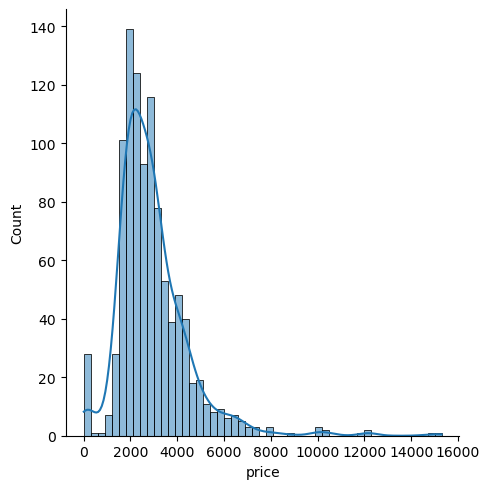

In [66]:
sns.displot(data=data, x='price', kde=True)

<AxesSubplot:xlabel='surface_living', ylabel='price'>

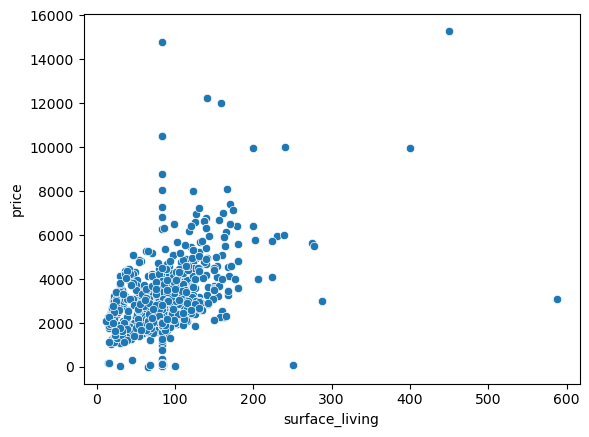

In [67]:
sns.scatterplot(data=data, x="surface_living", y="price")

There are clearly some outliers, and maybe mistakes in the data; Below I want to have a closer look at them:

In [68]:
data.query('surface_living > 300')

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
16,5.5,3095,Niederhasli,Villa,-2,588.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,13.0,15300,Zürich,Single house,-2,450.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,784.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
701,6.5,9981,Dietlikon,Row house,-2,400.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Looking at the point still with price almost 0 while being quite big; it's clearly a mistake (I cannot imagine that a single house would cost 90CF per month; seeing the other data points, it's much more probably 9000).

In [69]:
data.query('surface_living > 200 and price < 100')

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
18,7.5,90,Dübendorf,Single house,-2,250.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
data.iloc[18, 1] = 9000

Here we do actually see a duplicate, which I will drop; I will also drop the record at index=795, together with the one at index=16. </br>


In [71]:
data.query('surface_living < 100 and price > 10000')

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
795,5.5,14800,Erlenbach,Terrace flat,3,82.94,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
882,10.0,10500,Zürich,Villa,-2,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
883,10.0,10500,Zürich,Villa,-2,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
data = data.drop(index=[16, 795])

I cannot explain myself the high frequency (~7%) of houses of exactly 82.94m2 (the line of data points that goes straight up in the graph), but that's interesting:

In [73]:
len(data.query('surface_living == 82.94'))

71

We can see below, without the three dropped outliers, the graph looks already much better. </br>
We can also see (predictable) correlation between number of rooms, surface, and price.

<AxesSubplot:xlabel='surface_living', ylabel='price'>

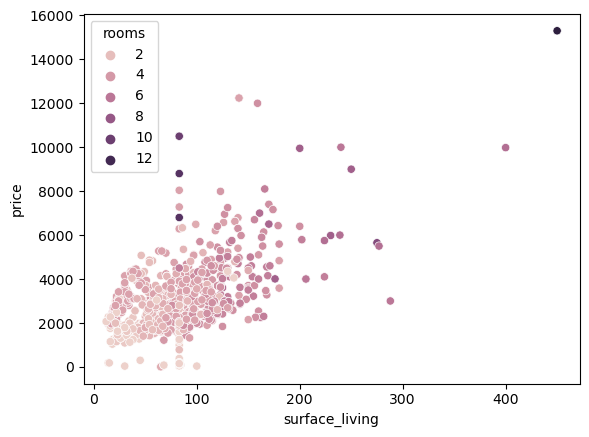

In [74]:
sns.scatterplot(data=data, x="surface_living", y="price", hue='rooms')

Let's have then a look at a plot between **price** and **type**:

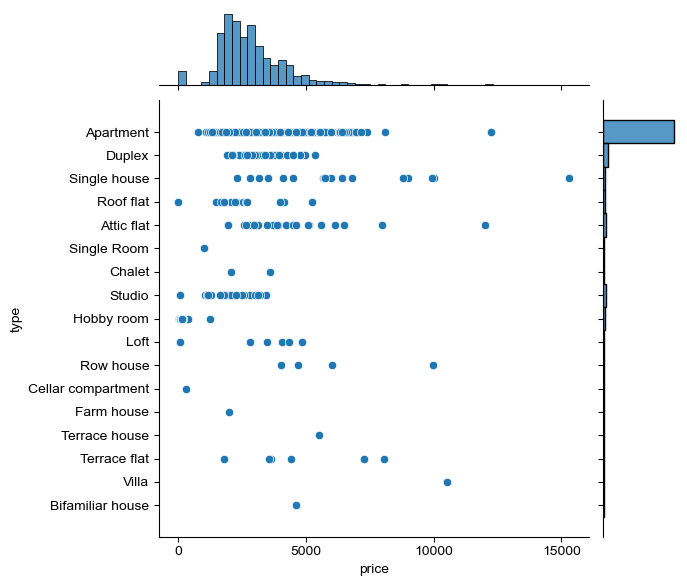

In [75]:
sns.jointplot(data=data, x='price', y='type')
sns.set(font_scale=1.5)

We can see from the plot above that the vast majority of the ads are apartments, and that their price mean is around 2000CF, with a distribution skewed to the right. There is also a curious amount of apartments that are for free, which I'm going to have a look at now:

In [76]:
data.query('price >= 0 and price <= 500')

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
35,3.0,4,Dietikon,Roof flat,3,65.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,1.0,36,Zürich,Hobby room,1,30.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,1.0,36,Zürich,Hobby room,1,100.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489,1.0,300,Glattbrugg,Cellar compartment,-1,45.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566,3.0,4,Dietikon,Roof flat,3,65.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,3.5,80,Zürich,Loft,5,84.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,1.0,80,Zürich,Studio,1,68.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,3.5,80,Zürich,Loft,5,84.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
676,1.0,80,Zürich,Studio,1,68.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,1.0,200,Zürich,Hobby room,1,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apart from the Hobby rooms, which can have a lower price tag (I re-checked on the website), flats or studios for less than 100 seem wrong. I will therefore inpute a value using the mean (or median if there are outliers) of each category.

- "**Roof flat**": It almost follows a normal distribution, but it's still skewed to the right. Since this causes a difference of ~300CF between mean and median, I will use the **median** value, which is closer to the value at the peak of the distribution.
- "**Loft**": The distribution is far from normal. I again will use the **median**
- "**Studio**": it's again a bit skewed. Will use the median as well.

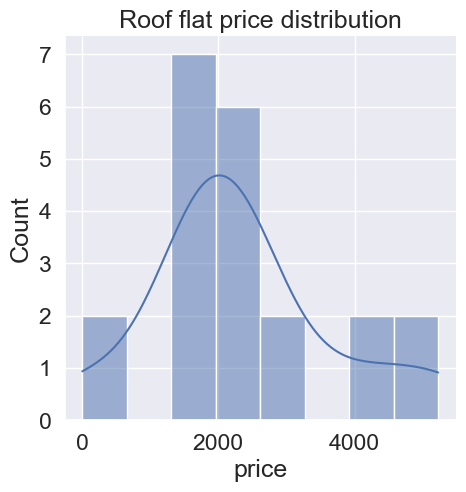

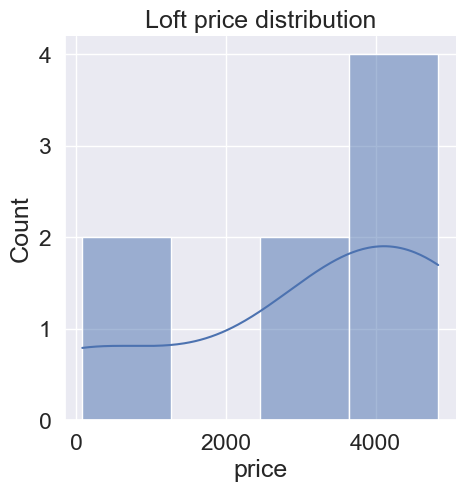

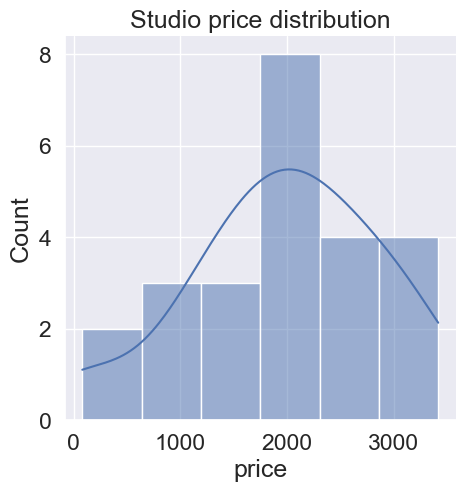

In [77]:
app_types = ['Roof flat', 'Loft', 'Studio']

for app in app_types:
    sns.displot(data = data.query(f'type == "{app}"')['price'], kde=True).set(title=f"{app} price distribution")

In [78]:
medians = {}

for app in app_types:
    medians[f'{app}'] = data.query(f'type == "{app}"')['price'].median()

Let's now replace the impossible values we had above with the medians:

In [79]:
for app in app_types:
    mask = (data['price'] >= 0) & (data['price'] <= 500) & (data['type'] == f'{app}')
    data.loc[mask, 'price'] = medians[f'{app}']

Lewt's check just a little part of the records above:

In [80]:
data.iloc[672:676]

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
673,3.5,3760,Zürich,Loft,5,84.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,1.0,2014,Zürich,Studio,1,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,3.5,3760,Zürich,Loft,5,84.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
676,1.0,2014,Zürich,Studio,1,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, the first plot should look a bit different; we can see that there are still some data points close to 0 which always sound strange when it's about a rental place, but they are all Hobby Rooms, and they are more prone to be cheaper.

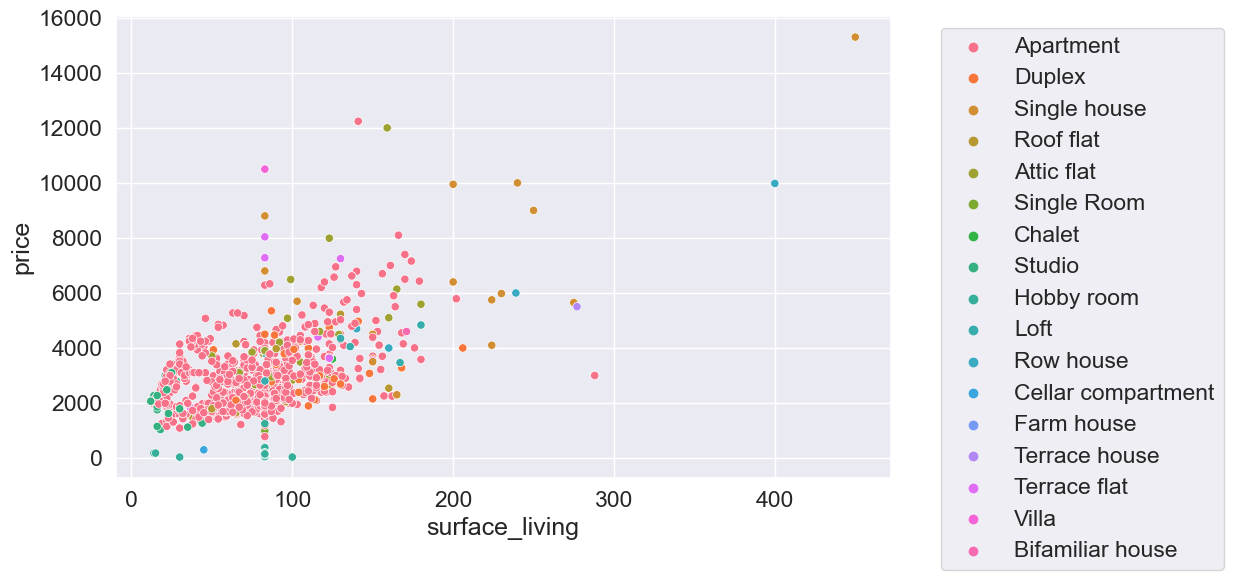

In [81]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=data, x="surface_living", y="price", hue='type')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [82]:
data.query('price < 100')

,rooms,price,address,type,floor,surface_living,pets_allowed,balcony_/_terrace,cable_tv,wheelchair_access,elevator,new_building,keller,storeroom,dishwasher,washing_machine,tumble_dryer,child-friendly,garage,minergie_certified,view,parking_space,covered,playground,minergie_construction,fireplace,land_area,old_building,power_connection,steamer,water_connection,waste_water_connection,attic_compartment,raised_ground_floor,gas_connection,quiet_neighborhood,mid-terrace_house,corner_house,swimming_pool,part_of_a_flat_share,approach_ramp_for_lorries
165,1.0,36,Zürich,Hobby room,1,30.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,1.0,36,Zürich,Hobby room,1,100.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,1.0,51,Benglen,Hobby room,1,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,1.0,51,Benglen,Hobby room,1,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
947,1.0,50,Meilen,Hobby room,1,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
948,1.0,50,Meilen,Hobby room,1,82.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
cols = ['rooms', 'price', 'type', 'address', 'surface_living']
subset = data[cols].copy()

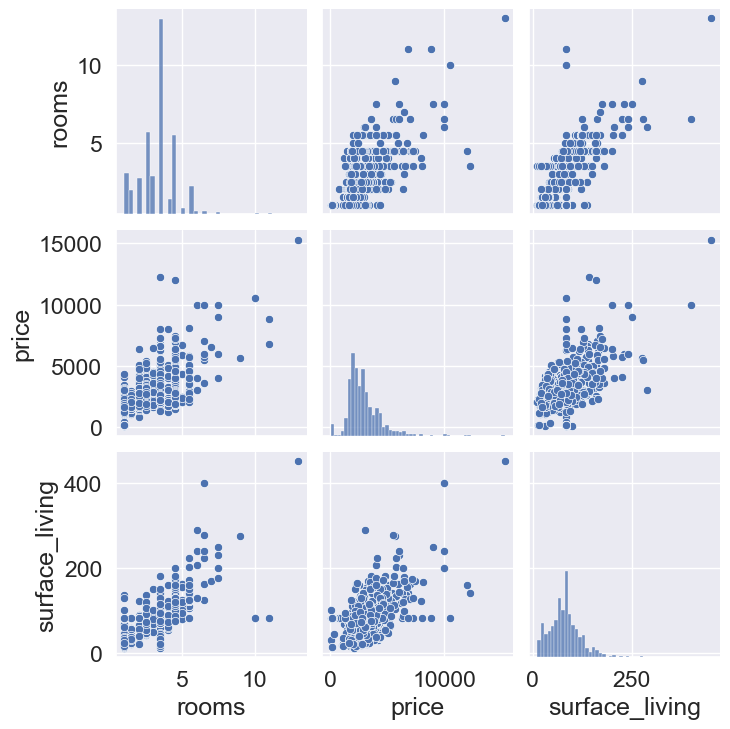

In [84]:
sns.pairplot(data=subset)

Let's now have a look at the **correlation matrices**.
 
However, since no feature has a correlation > 85, I will leave all features there.

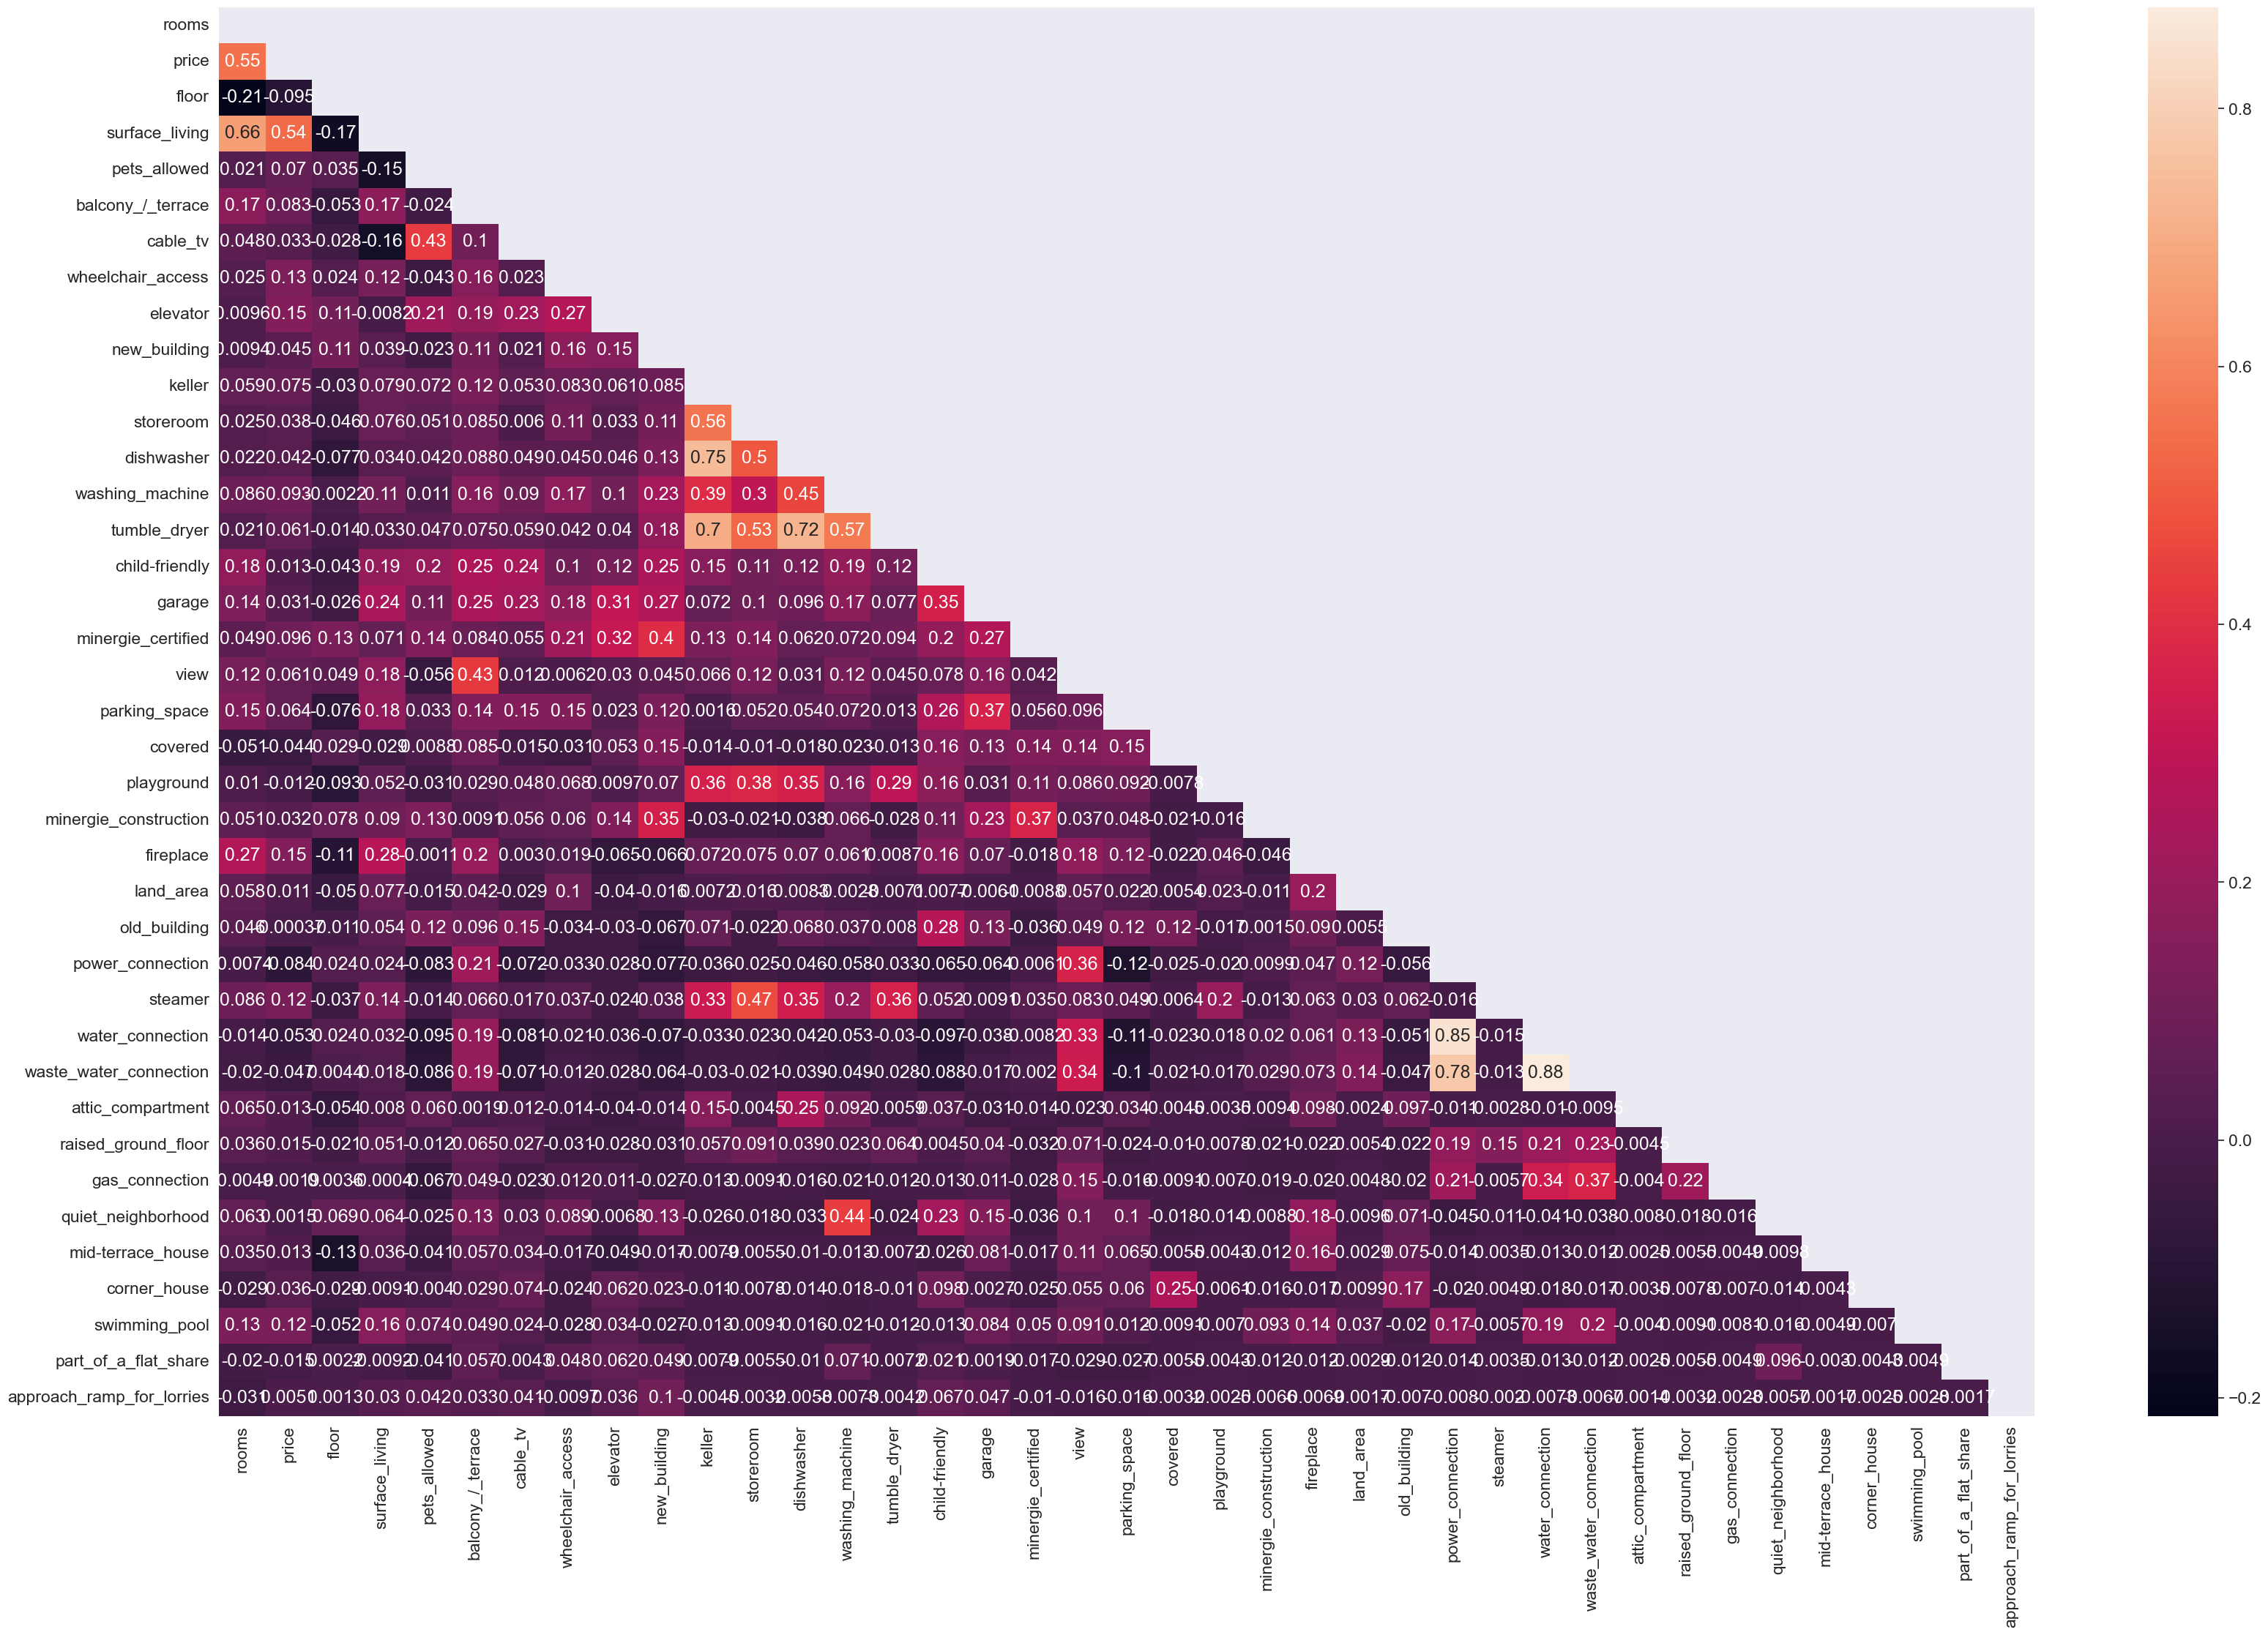

In [85]:
corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(40, 25)) 
sns.heatmap(corr_matrix, annot=True, mask=mask)
sns.set(font_scale=1.5)
plt.show()

# Data manipulation
I already manipulated some data above, here I mainly want to encode the data and normalize the target variable if needed.

### Encoding the data
Since I have a lot of values for the address column and for the house type, I will use the Label encoder to avoid the creation of too many more columns. </br>
Because there are 93 values for the addresses and 17 for the house types, I will create a new column each with label encoded data.

In [86]:
# Address
address_label_encoder = LabelEncoder()
data['encoded_address'] = address_label_encoder.fit_transform(data['address'])
address_dict = dict(zip(data['address'], data['encoded_address']))

# Type
type_label_encoder = LabelEncoder()
data['encoded_type'] = type_label_encoder.fit_transform(data['type'])
type_dict = dict(zip(data['type'], data['encoded_type']))

Creating a new dataframe with the new columns, and dropping the encoded columns from the original df

In [87]:
e_data = data.drop(columns=['address', 'type'], axis=1).copy()
data = data.drop(columns=['encoded_address', 'encoded_type'], axis=1)

In [88]:
# Re-arranging the columns
e_data = e_data[['rooms', 'price', 'encoded_address', 'encoded_type', 'floor', 'surface_living', 'pets_allowed',
       'balcony_/_terrace', 'cable_tv', 'wheelchair_access', 'elevator',
       'new_building', 'keller', 'storeroom', 'dishwasher', 'washing_machine',
       'tumble_dryer', 'child-friendly', 'garage', 'minergie_certified',
       'view', 'parking_space', 'covered', 'playground',
       'minergie_construction', 'fireplace', 'land_area', 'old_building',
       'power_connection', 'steamer', 'water_connection',
       'waste_water_connection', 'attic_compartment', 'raised_ground_floor',
       'gas_connection', 'quiet_neighborhood', 'mid-terrace_house',
       'corner_house', 'swimming_pool', 'part_of_a_flat_share',
       'approach_ramp_for_lorries']]

In [89]:
# transforming the type of the columns in integers instead of floats
cols = ['floor', 'pets_allowed',
       'balcony_/_terrace', 'cable_tv', 'wheelchair_access', 'elevator',
       'new_building', 'keller', 'storeroom', 'dishwasher', 'washing_machine',
       'tumble_dryer', 'child-friendly', 'garage', 'minergie_certified',
       'view', 'parking_space', 'covered', 'playground',
       'minergie_construction', 'fireplace', 'land_area', 'old_building',
       'power_connection', 'steamer', 'water_connection',
       'waste_water_connection', 'attic_compartment', 'raised_ground_floor',
       'gas_connection', 'quiet_neighborhood', 'mid-terrace_house',
       'corner_house', 'swimming_pool', 'part_of_a_flat_share',
       'approach_ramp_for_lorries']

e_data[cols] = e_data[cols].astype(int)

### Log

Above we saew that the price has some big outliers, but I removed some data entries later. Let's see how the distribution looks like now. </br>
There are still some big outliers, so I will apply the log function to them.</br>

**Edit**: Log transformation doesn't work, it skewes the data to the left instead of the right. I will try some models first, and, if needed, drop the outliers. </br>
I will try dropping the outliers to see if the model performs better.

- 1st iteration: 
    - MSLE: 0.1267595203224698
    - R2: 0.599425531148881
    
- 2nd iteration:
    - MSLE: 0.12180809524013536
    - R2: 0.5897637032849165
    


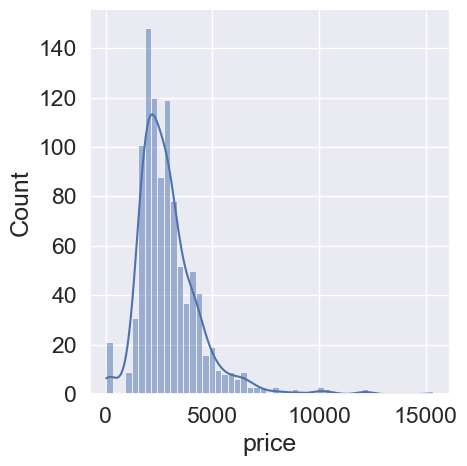

In [90]:
sns.displot(data=data, x='price', kde=True)

# ML 

- Random Forest regressor
- XGBoost

## X/y and train/test split

In [91]:
x = e_data.drop(columns=['price'], axis=1)
y = e_data['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

## Random Forest

#### Initialize RandomForest Regressor:

- random_state ==> setting a random state ensures that each time the code is ran, the results are the same


In [92]:
rf = RandomForestRegressor(random_state=1)

#### Initialize parameters for the **grid_search**

- **n_estimators**: Specifies the number of trees in the Random Forest. A larger value of n_estimators generally leads to a more robust and accurate model, but it also increases the computational cost.

- **max_depth**: Controls the maximum depth of each individual decision tree in the Random Forest. A larger value of max_depth can lead to a more complex model, which may be prone to overfitting. A smaller value of max_depth can lead to a simpler model, which may be prone to underfitting.

- **min_samples_split**: Controls the minimum number of samples required to split an internal node in each decision tree. A smaller value of min_samples_split can lead to a more complex model, which may be prone to overfitting. A larger value of min_samples_split can lead to a simpler model, which may be prone to underfitting.

- **min_samples_leaf**: Controls the minimum number of samples required to be at a leaf node in each decision tree. A smaller value of min_samples_leaf can lead to a more complex model, which may be prone to overfitting. A larger value of min_samples_leaf can lead to a simpler model, which may be prone to underfitting.

In [93]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

- Initiaize Grid Search with 5-fold cross validation and negative RMSE
</br>
- Why a negative scoring? ==> GridSearchCV uses the scoring function to rank the models generated by the grid search. A higher score indicates better performance, so GridSearchCV uses the negative of the RMSE to rank the models.
- n_jobs ==> Use all CPUs instead of only one

In [94]:
tuned_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

#### Fit model on training data

In [95]:
tuned_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_mean_squared_error')

#### Find best parameters

In [96]:
best_params = tuned_rf.best_params_
print(f'best params: {best_params}')

best params: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


#### Get best model and make predictions on test data

In [97]:
best_model = tuned_rf.best_estimator_
predictions = best_model.predict(X_test)

#### Evaluate the best model
I will use mean_squared_log_error and R squared, because my target variable was skewed to the left, and the logarithmic transfrmation couldn't normalize it.

- MSLE = 0 => Best value
- 0 < R < 1 => 1 is best value

In [98]:
scores = pd.DataFrame({
    'Model': [],
    'Metric':[],
    'Value':[]
})

In [99]:
msle = mean_squared_log_error(y_test, predictions)
r_squared = r2_score(y_test, predictions) 

print(f'Mean Squared Log Error: {msle}')
print(f'R Squared: {r_squared}')

Mean Squared Log Error: 0.1267595203224698
R Squared: 0.599425531148881


## XGBoost

In [100]:
# pip install xgboost

### Pipeline
First of all, we will need to build a pipeline of training:

In [101]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

estimators = [
    ('clf', XGBRegressor(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,


### Hyperparameter tuning

In [102]:
# pip install scikit-optimize

In [103]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=5, n_iter=10, scoring='r2', random_state=8) 

### Train model

In [104]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                  

### Model Evaluation and predictions

In [105]:
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=0.6854728136721551,
                              colsample_bynode=0.9716292421559054,
                              colsample_bytree=0.9999681720272138, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.269342703724346,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.4165635668761467, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_const

In [106]:
opt.best_score_

0.6082835777708198

In [107]:
opt.score(X_test, y_test)

0.680641417637518

In [108]:
predictions = opt.predict(X_test)

In [109]:
msle = mean_squared_log_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

print(f'Mean Squared Log Error: {msle}')
print(f'R Squared: {r_squared}')

Mean Squared Log Error: 0.12564608227557195
R Squared: 0.680641417637518


# Conclusion

We can state that XGBoost is a much better classifier than Random Forest, giving almost an R2 of 0.7 compared to Random forest, where the same Error metric was almost 0.6; we will therefore prefer the latter.

Thank you for reading and for any suggestions!